In [1]:
from time import time
from matplotlib.colors import Normalize
from matplotlib.cm import Spectral

from tool_create_substrate import gaussian, calc_matrices_bvect, substrate_from_params
from tool_create_cluster import rotate, get_rotomatr
from tool_reciprocal_space import get_analW, get_lat, FTinterpolate, VG, find_matching_lat, get_Nl_gauss
from misc import get_brillouin_zone_2d, plot_BZ2d, plot_UC, plt_cosmetic

from itertools import cycle
colors = ['r', 'b', 'g', 'k', 'pink','orange']
markers = ['x', '+', '.', 's']
lstyles = ['-', '--', '-.', ':']
if len(markers) == len(colors):  print('!!! You may want to have incommensurate colors and markers to enhances combinaitons')
colors = cycle(colors)
markers = cycle(markers)
lstyles = cycle(lstyles)

# 2pi shortcut
pi2 = 2*np.pi

def plot_lat(ax, L, color='blue', UC=True, WS=True, points=True, vects=True):
    if UC: plot_UC(ax, L, {'color': color, 'ls': ':'})
    if WS: plot_BZ2d(ax, get_brillouin_zone_2d(L), {'color': color, 'ls': '--', 'fill': False})
    if points: 
        for p in [i*L[0]+j*L[1] for i in [-1,0,1] for j in [-1,0,1]]:
            ax.plot(p[0],p[1], '+', color=color)
    if vects: ax.quiver([0,0],[0,0], L[:,0], L[:,1], color=color, angles='xy', scale_units='xy', scale=1)

In [42]:
# --- Sub
aa = 1
a1, a2 = aa*np.array([1,0]), aa*np.array([0,1])
S = np.array([a1,a2])
AS = np.linalg.det(S) # Substrate unit cell area
print(S, AS)
G = pi2*np.linalg.inv(S).T 
u, u_inv = calc_matrices_bvect(S[0], S[1]) # keep track of how to go back!
B = u.T
Binv = np.linalg.inv(B)
S0 = B@S
G0 = pi2*np.linalg.inv(S0).T 

# --- Ads
theta = 15
bb = sqrt(3/2)
b1, b2 = bb*np.array([1,0]), bb*np.array([-1/2, sqrt(3)/2])
T = np.array([b1,b2])
T = rotate(T, theta)
Q = pi2*np.linalg.inv(T).T 
T0 = B@T # move to S-reduced space
Q0 = pi2*np.linalg.inv(T0).T 

[[1 0]
 [0 1]] 1.0


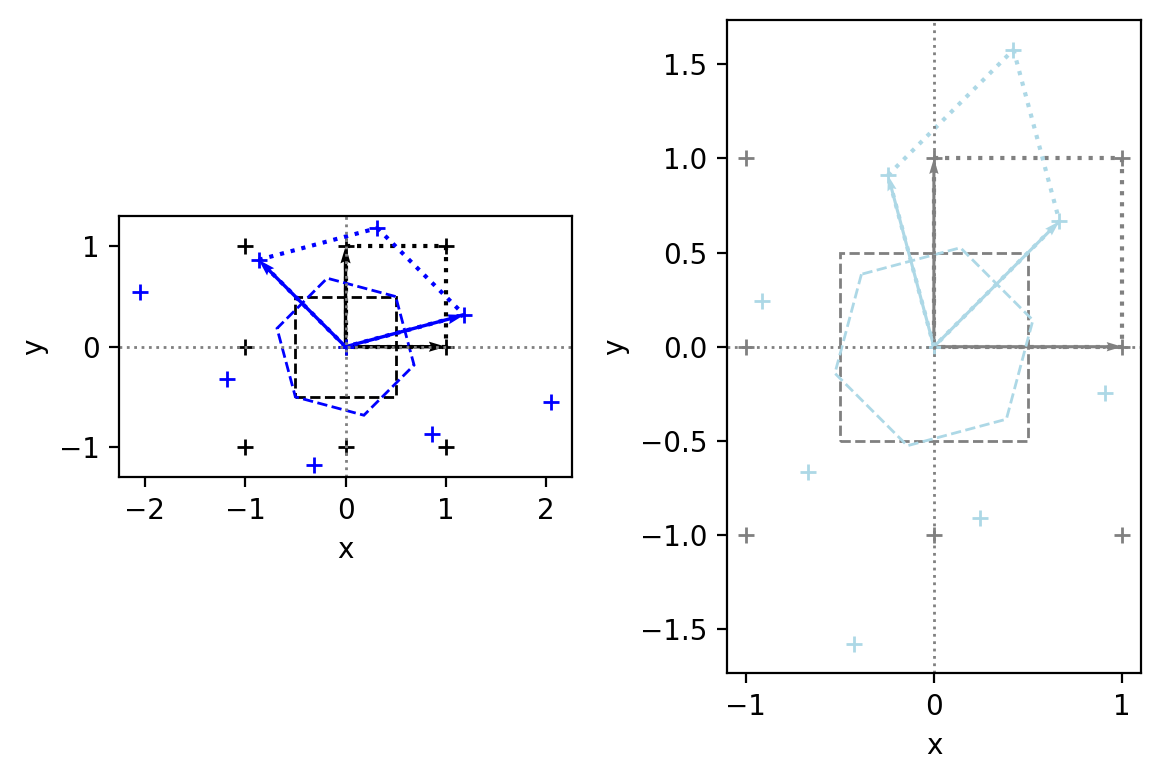

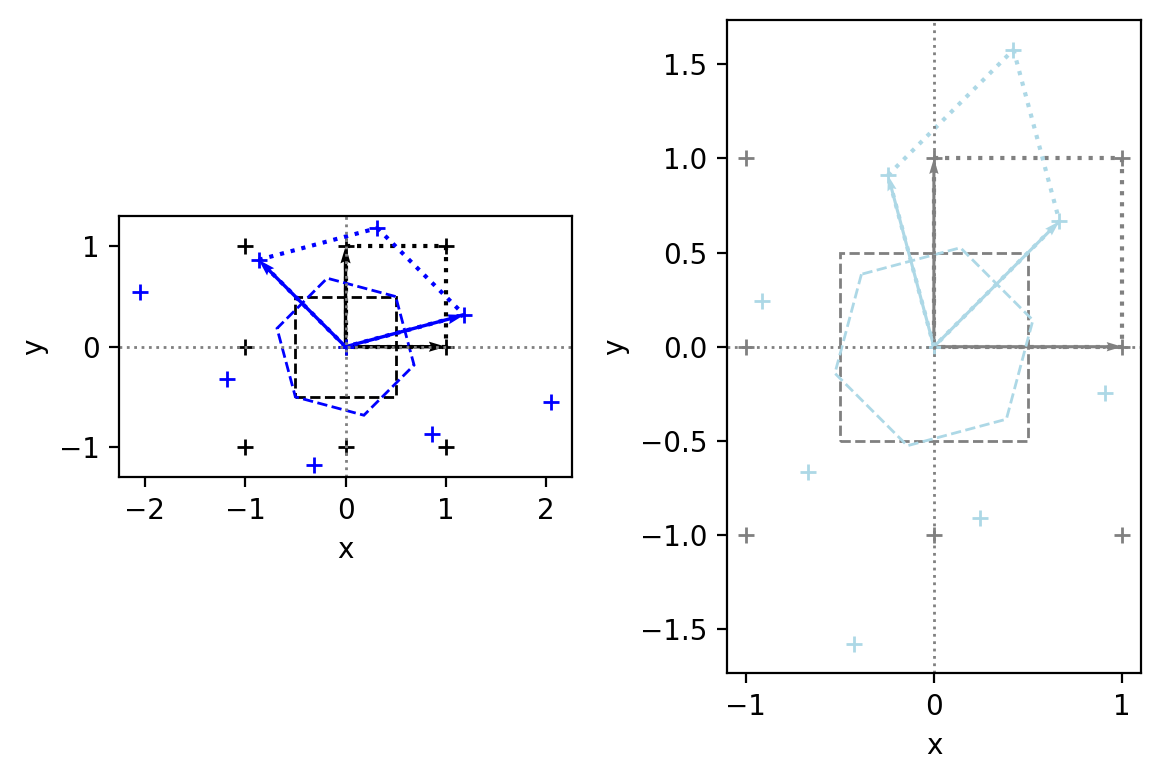

In [12]:
# Cart real space
fig, (axReal, axRedu) = plt.subplots(1,2, dpi=200)
plot_lat(axReal, S, color='k') # deformed substrate
plot_lat(axReal, T, color='blue') # undeformed colloid
plt_cosmetic(axReal)

# Cart rec space
plot_lat(axRedu, G/pi2, color='gray') # substrate recspace
plot_lat(axRedu, Q/pi2, color='lightblue') # coll recspace
plt_cosmetic(axRedu)
plt.tight_layout()
plt.show()

# Reduced real space
fig, (axReal, axRedu) = plt.subplots(1,2, dpi=200)
plot_lat(axReal, S0, color='k') 
plot_lat(axReal, T0, color='blue')
plt_cosmetic(axReal)

# Redu Rec space 
plot_lat(axRedu, G0/pi2, color='gray') # substrate recspace
plot_lat(axRedu, Q0/pi2, color='lightblue') # coll recspace
plt_cosmetic(axRedu)
plt.tight_layout()
plt.show()

In [13]:
# Substrare well shape
sigma = 0.1*aa
# Size

Nl = 121**2
N = Nl
cl_shape = 'special'

print('Size lattice points Nl=%i sigma=%.4g' % (N, sigma))
params = {
    # --- SUBSTRATE ---
    'sub_basis': [[0,0]],
    'b1': S[0],
    'b2': S[1],
    'epsilon': 1,
    'well_shape': 'gaussian',
    'sigma': sigma, 'a': 0.98*aa, 'b': 0.99*aa,
    # --- CLUSTER ---
    'a1': T[0], 'a2': T[1],
    'cl_basis': [[0,0]], # no basis
    'cluster_shape': cl_shape,
    'N1': Nl, 'N2': Nl,
    'theta': 0.0, 'pos_cm': [0, 0] 
}

pen_func, en_func, en_inputs = substrate_from_params(params)

Size lattice points Nl=14641 sigma=0.1


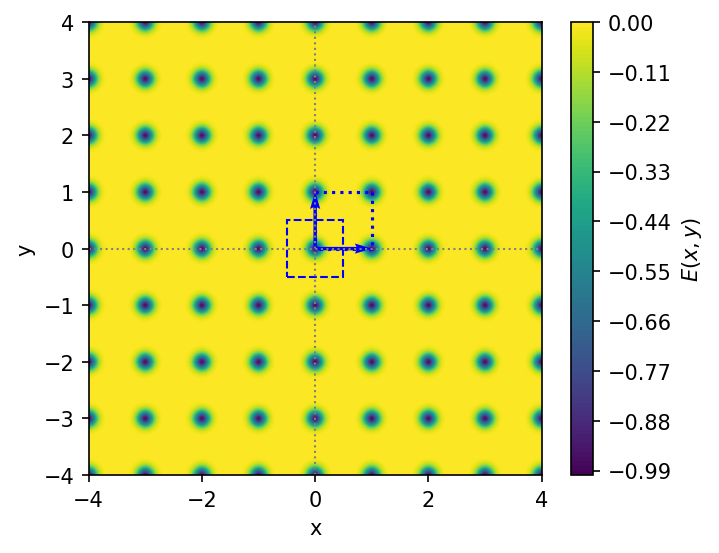

In [14]:
# --- Cart space ---
x0, x1, nx = -4, 4, 200
y0, y1, ny = -4, 4, 200
# Two Grids NxN
xx, yy = np.meshgrid(np.linspace(x0, x1, nx), np.linspace(y0, y1, ny))
# One Grid NxNx2
pp = np.stack([xx, yy], axis=2)
# Points N^2x2
p = np.reshape(pp, (pp.shape[0]*pp.shape[1], 2))

# Compute energy
en, F, tau = pen_func(p, [0,0], *en_inputs)

# Plot
fig, axE = plt.subplots(1,1, dpi=100, sharex=True, sharey=True, figsize=(5,4))
plt_params = {'ls': '--', 'color': 'tab:gray', 'lw': 1, 'fill': False}
s0 = 1
#sc = axE.scatter(p[:,0], p[:,1], c=en, s=s0)
engg = np.reshape(en, (xx.shape[0], yy.shape[0]))
sc = plt.contourf(xx, yy, engg,
                  levels=100
                 )
plt.colorbar(sc, label=r'$E(x,y)$', ax=axE)
plot_lat(plt.gca(), S, points=False)
axE.set_xlim([x0, x1])
axE.set_ylim([y0, y1])
axE.set_ylabel('y')
axE.set_xlabel('x')
axE.set_aspect('equal')
plt_cosmetic(axE)
plt.gcf().set_dpi(150)
plt.show()

# --- Rec space ---
# p0 = np.dot(B.T, p.T).T
# # Plot
# fig, axE = plt.subplots(1,1, dpi=100, sharex=True, sharey=True, figsize=(5,4))
# plt_params = {'ls': '--', 'color': 'tab:gray', 'lw': 1, 'fill': False}
# s0 = 5
# sc = axE.scatter(p0[:,0], p0[:,1], c=en, s=s0)
# plt.colorbar(sc, label=r'$E(x,y)$', ax=axE)
# plot_BZ2d(axE, get_brillouin_zone_2d(S0),plt_params)
# axE.quiver(0, 0, *S0[0], angles='xy', scale_units='xy', scale=1, zorder=5, color='red', label='b1')
# axE.quiver(0, 0, *S0[1], angles='xy', scale_units='xy', scale=1, zorder=5, color='orange', label='b2')
# axE.legend(loc='upper right')
# axE.set_xlim([-1., 1.])
# axE.set_ylim([-1., 1.])
# axE.set_ylabel('y')
# axE.set_aspect('equal')
# plt_cosmetic(axE)
# plt.show()

# Rec space analysis

In [17]:
print('Size N=%i' % N)
print('sigma=%.4g' % sigma)
# --- Substrate lattice side
# --- --- Fixed
# Nl_side = 1
# --- --- Up to amplitude of substrate potential # careful with G/hBN with tiny sigma. Use fix
Nl_side = get_Nl_gauss(1e-50, sigma, aa)
# --- --- Sub rec lattice
Glat = get_lat(G, Nl_side) # Cart rec space sub
#G0lat = np.dot(Binv, Glat.T).T # Redu rec space sub
Gmax = np.max(np.linalg.norm(Glat, axis=1))
print('Nl=', Nl_side, 'max |G|', Gmax, 'max VG', VG(Gmax, sigma, AS))
# --- Ads lattice
Nl_side2 = int(np.ceil(Nl_side*bb/aa)) # consider mismatch
Qlat = get_lat(Q, Nl_side2)
Qmax = np.max(np.linalg.norm(Qlat, axis=1))
print('Nl=', Nl_side2, 'max |Q|', Qmax)
 
# ---- Filter -----
# wfilter = {'abs': 1e-5} # asbolute value
wfilter = {'n': 10} # first n component
# wfilter = {'rel': 1e-7} # relative to VG(0)

G_s, dOmega_s, W_s, VG_s, mask = find_matching_lat(S, T, N, sigma, wfilter=wfilter, Nl_side=Nl_side)

print('Selected %i FT components' % len(G_s), '(%i uniq weights)' % len(np.unique(np.abs(W_s*VG_s))))
logweight = np.log10(np.abs(W_s*VG_s)) # show weight in log scale, more contrast
VG0 = -VG_s[np.argmin(np.linalg.norm(G_s, axis=1))] # zeroth Fourier is average of substrate
print(VG0)
#print('check', -VG_s[np.argmin(np.linalg.norm(G0_s, axis=1))])

Size N=14641
sigma=0.1
Nl= 17 max |G| 151.05801989738444 max VG 8.97535941896611e-52
Nl= 21 max |Q| 215.46837146719318
Selected 19 FT components (10 uniq weights)
-0.03183098861837907


/Users/andreasilva/Documents/Post_doc-SISSA/software/rigid_cluster/example/tool_reciprocal_space.py:11: RuntimeWarning: invalid value encountered in true_divide
  p1 = np.sin(c_dot[:,0]*np.sqrt(N)/2)/np.sin(c_dot[:,0]/2)/np.sqrt(N)
/Users/andreasilva/Documents/Post_doc-SISSA/software/rigid_cluster/example/tool_reciprocal_space.py:12: RuntimeWarning: invalid value encountered in true_divide
  p2 = np.sin(c_dot[:,1]*np.sqrt(N)/2)/np.sin(c_dot[:,1]/2)/np.sqrt(N)


Avg value VG0=-0.031830989
Selcted within weight {'n': 10} at size 14641
  0) G=(      -4,       -4) VG=5.75e-05 W=       1 (VG*W=  5.75e-05) dOmg(G)=( 7.7e-16, -8.5e-17)
  1) G=(      -3,       -3) VG=0.000912 W= 0.00826 (VG*W=  7.53e-06) dOmg(G)=(   -0.33,    -0.33)
  2) G=(      -2,       -2) VG= 0.00656 W=       1 (VG*W=   0.00656) dOmg(G)=( 3.9e-16, -4.3e-17)
  3) G=(       0,       -2) VG=  0.0145 W=7.67e-05 (VG*W=  1.11e-06) dOmg(G)=(    0.18,     0.49)
  4) G=(      -2,       -1) VG=  0.0119 W= 0.00011 (VG*W=  1.31e-06) dOmg(G)=(    0.24,    0.089)
  5) G=(      -1,       -1) VG=  0.0214 W= 0.00826 (VG*W=  0.000177) dOmg(G)=(   -0.33,    -0.33)
  6) G=(       0,       -1) VG=  0.0261 W= 0.00011 (VG*W=  2.88e-06) dOmg(G)=(   -0.24,   -0.089)
  7) G=(       1,       -1) VG=  0.0214 W=0.000134 (VG*W=  2.87e-06) dOmg(G)=(   -0.15,     0.15)
  8) G=(      -1,        0) VG=  0.0261 W= 8.3e-05 (VG*W=  2.17e-06) dOmg(G)=(  -0.089,    -0.24)
  9) G=(       0,        0) VG=  0.0318 W=   

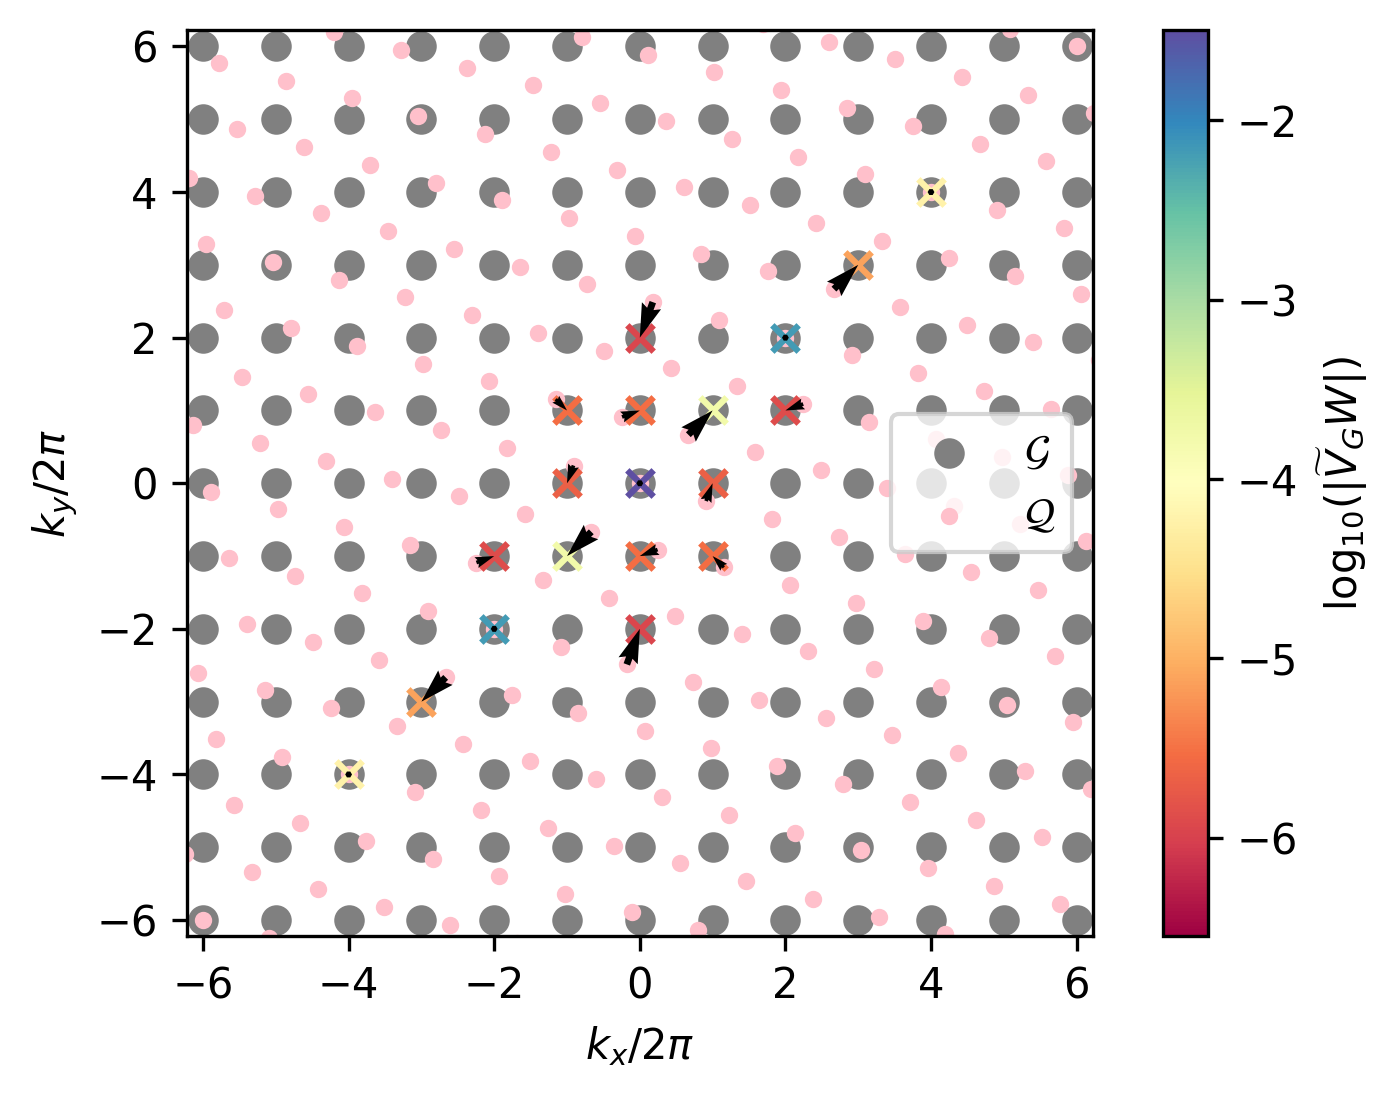

In [18]:
# --- PLOT / ANALYSIS
s0 = 40
cmap = Spectral
norm = Normalize(np.min(logweight)*1.1, np.max(logweight))

plt.scatter(Glat[:,0]/pi2, Glat[:,1]/pi2, color='gray', marker='o', s=s0, label=r'$\mathcal{G}$')
plt.scatter(Qlat[:,0]/pi2, Qlat[:,1]/pi2, color='pink', marker='.', s=s0, label=r'$\mathcal{Q}$')

plt.legend()

print('Avg value VG0=%.8g' % VG0)
print('Selcted within weight %s at size %i' % (str(wfilter), N))
for i in range(logweight.shape[0]):
    #c = next(colors)
    m = next(markers)    
    c = logweight[i]
    sc = plt.scatter(G_s[i,0]/pi2, G_s[i,1]/pi2,
                     marker='x', c=c, s=s0, norm=norm, cmap=cmap)
    plt.quiver(*(G_s-dOmega_s)[i]/pi2,
               *dOmega_s[i]/pi2,
               scale_units='xy', angles='xy', scale=1
              )
    log_string = '%3i) G=(%8.2g, %8.2g) VG=%8.3g W=%8.3g (VG*W=%10.3g) dOmg(G)=(%8.2g, %8.2g)'
    print(log_string  % (i, *G_s[i]/pi2, VG_s[i], W_s[i], VG_s[i]*W_s[i], *dOmega_s[i]/pi2))
plt.colorbar(sc, label=r'$\log_{10}(|\widetilde{V}_GW|)$')

# plt.plot(Glat[mask[0]][0]/pi2, Glat[mask[0]][1]/pi2, '*', color='yellow')

# plt.quiver([0,0],[0,0], G[:,0]/pi2, G[:,1]/pi2, color='red', angles='xy', scale_units='xy', scale=1)
# plt.quiver([0,0],[0,0], Q[:,0]/pi2, Q[:,1]/pi2, color='blue', angles='xy', scale_units='xy', scale=1)
# plt.quiver([0,0],[0,0], T[:,0], T[:,1], color='orange', angles='xy', scale_units='xy', scale=1)
# plt.quiver([0,0],[0,0], -T[:,0], -T[:,1], color='orange', angles='xy', scale_units='xy', scale=1)
# rT = rotate(T.copy(), 90)
# plt.quiver([0,0],[0,0], rT[:,0], rT[:,1], color='green', angles='xy', scale_units='xy', scale=1)
# plt.quiver([0,0],[0,0], -rT[:,0], -rT[:,1], color='green', angles='xy', scale_units='xy', scale=1)

plt.gca().set_aspect('equal')
plt.gcf().set_dpi(300)
Gs_max = 1.1*np.max(np.linalg.norm(G_s, axis=1)/(2*pi))
plt.xlim([-Gs_max, Gs_max])
plt.ylim([-Gs_max, Gs_max])
plt.xlabel(r'$k_x/2\pi$')
plt.ylabel(r'$k_y/2\pi$')
# plt.xlim([-3,3])
# plt.ylim([-3,3])
plt.show()



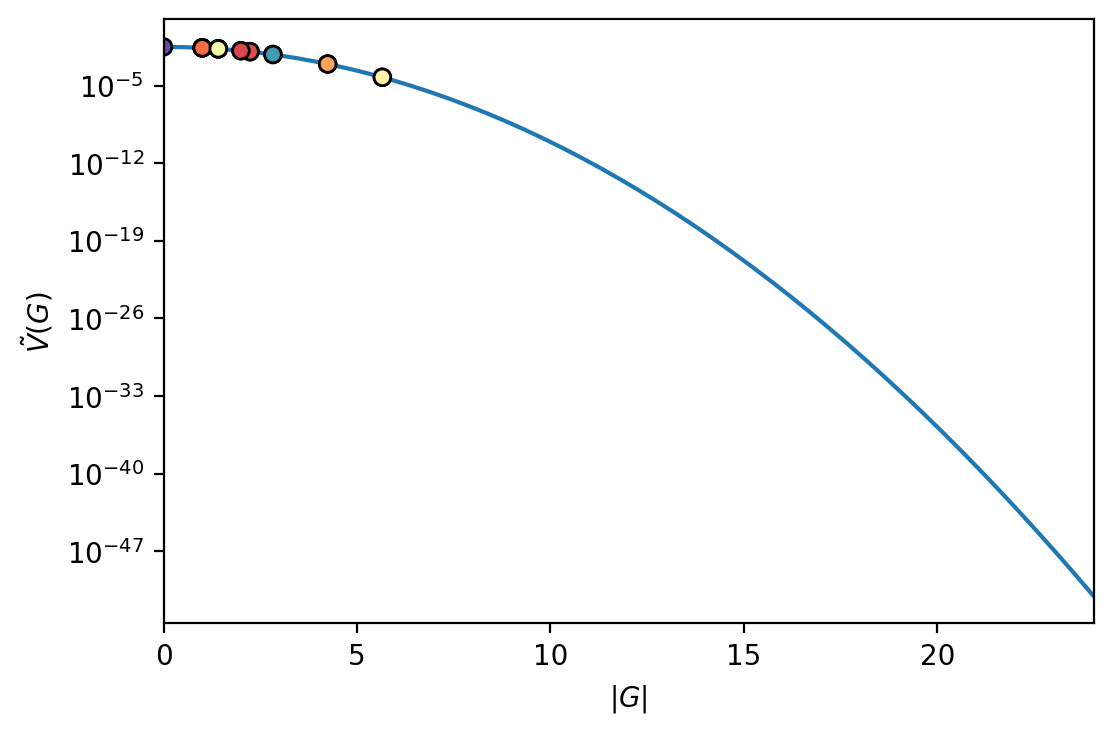

In [22]:
# Lattice point FT component
gg = np.linspace(0,Gmax)
plt.plot(gg/pi2, VG(gg, sigma, AS))

Gn = np.linalg.norm(G_s, axis=1)
plt.scatter(Gn/pi2, VG(Gn, sigma, AS), c=logweight, marker='o', ec='k', cmap=cmap, norm=norm, zorder=2)
# plt.axhline(w0, ls='-.', color='r')   
# plt.axvline(xt, ls=':', color='gray', lw=0.5)
# plt.axhline(t, ls=':', color='gray', lw=0.5)
plt.yscale('log')
plt.xlabel(r'$|G|$')
plt.ylabel(r'$\tilde{V}(G)$')
plt.xlim([0,Gmax/pi2])
plt.gcf().set_dpi(200)

/Users/andreasilva/Documents/Post_doc-SISSA/software/rigid_cluster/example/tool_reciprocal_space.py:11: RuntimeWarning: invalid value encountered in true_divide
  p1 = np.sin(c_dot[:,0]*np.sqrt(N)/2)/np.sin(c_dot[:,0]/2)/np.sqrt(N)
/Users/andreasilva/Documents/Post_doc-SISSA/software/rigid_cluster/example/tool_reciprocal_space.py:12: RuntimeWarning: invalid value encountered in true_divide
  p2 = np.sin(c_dot[:,1]*np.sqrt(N)/2)/np.sin(c_dot[:,1]/2)/np.sqrt(N)
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  app.launch_new_instance()


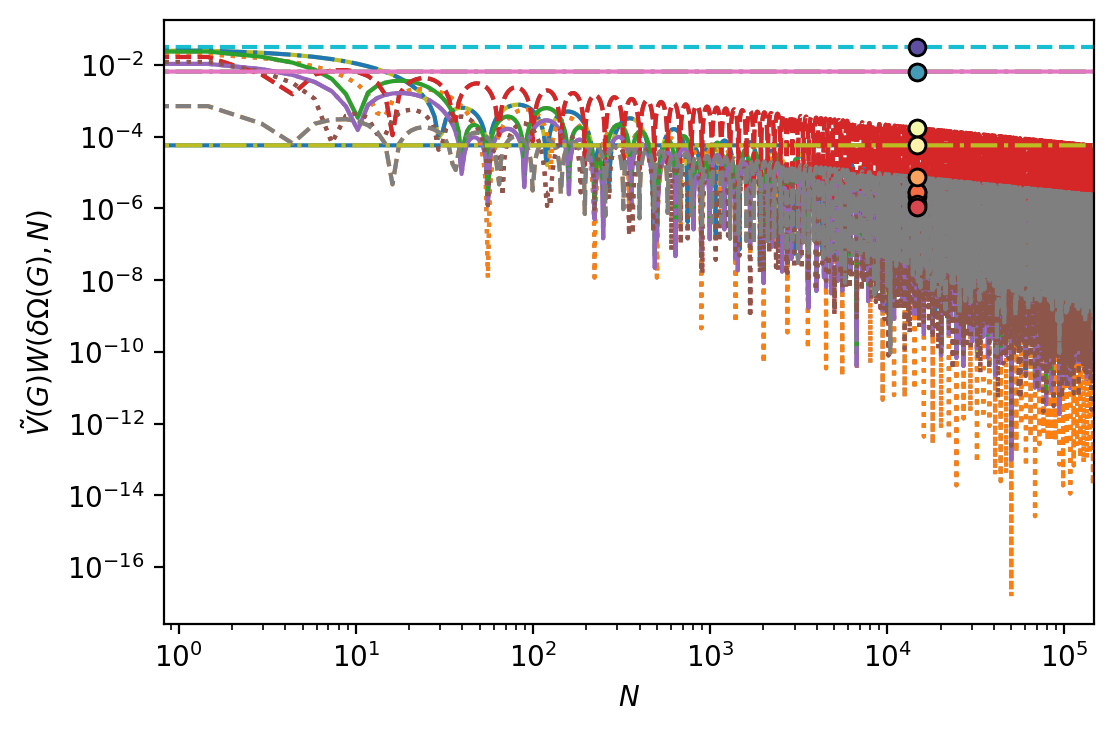

In [23]:
# Weight of each substrate lattice
NN = np.linspace(0, 10*N, int(1e5))
for i in range(dOmega_s.shape[0]):    
    ls = next(lstyles)
    c_W = get_analW(dOmega_s[i], T, NN)
    plt.plot(NN, np.abs(VG_s[i]*c_W), ls=ls, zorder=1)
    plt.scatter(N, np.abs(VG_s[i]*W_s[i]), c=logweight[i], 
               marker='o', ec='k', cmap=cmap, norm=norm, zorder=2)

# plt.ylim([5e-6,1e-1])
#plt.ylim([5e-4,1.1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$N$')
plt.ylabel(r'$\tilde{V}(G) W(\delta\Omega(G), N)$')
plt.xlim([NN[0], NN[-1]])
plt.gcf().set_dpi(200)

# Fourier interpolation

/Users/andreasilva/Documents/Post_doc-SISSA/software/rigid_cluster/example/tool_reciprocal_space.py:11: RuntimeWarning: invalid value encountered in true_divide
  p1 = np.sin(c_dot[:,0]*np.sqrt(N)/2)/np.sin(c_dot[:,0]/2)/np.sqrt(N)
/Users/andreasilva/Documents/Post_doc-SISSA/software/rigid_cluster/example/tool_reciprocal_space.py:12: RuntimeWarning: invalid value encountered in true_divide
  p2 = np.sin(c_dot[:,1]*np.sqrt(N)/2)/np.sin(c_dot[:,1]/2)/np.sqrt(N)
/Users/andreasilva/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:4192: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


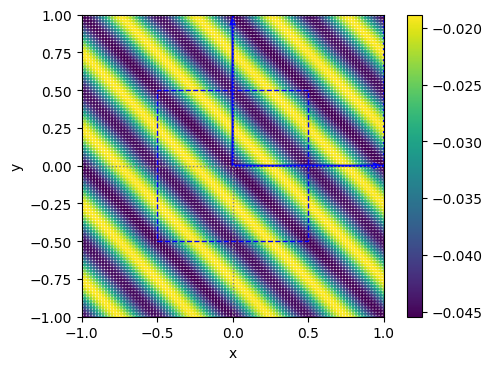

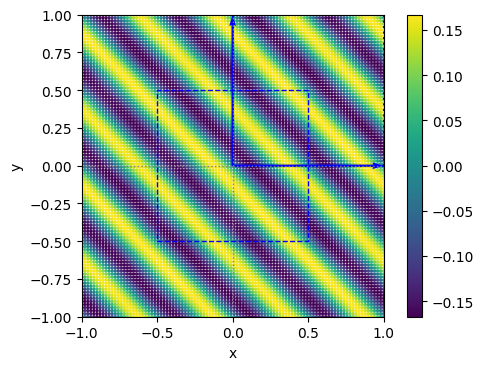

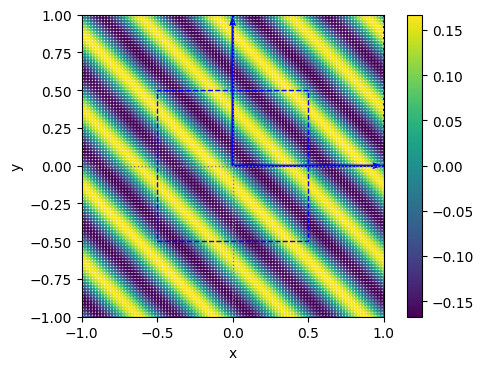

In [29]:
pp_dens = 100
pside = 1
nnFT = np.reshape(np.meshgrid(np.linspace(-pside, pside, pp_dens), np.linspace(-pside, pside, pp_dens)), 
                 (2,(pp_dens)**2)).T
ppFT = nnFT@S
enFT, FxFT, FyFT = FTinterpolate(ppFT, dOmega_s, G_s, N, T, sigma, AS)
enFT, FxFT, FyFT = enFT, FxFT.real, FyFT.real
#-------------------- PLOT
for ccol in [enFT, FxFT, FyFT]:
    sc = plt.scatter(ppFT[:,0], ppFT[:,1], c=ccol, s=2, zorder=-1)
    plt.colorbar(sc)

    plot_lat(plt.gca(), S, points=False)
    plt_cosmetic(plt.gca())
    
    plt.xlim([-pside, pside])
    plt.ylim([-pside, pside])

    plt.gcf().set_dpi(100)      
    plt.show()

# Discrete real space calculation

In [30]:
from matplotlib.colors import Normalize

# Substrate
from tool_create_substrate import calc_matrices_bvect
from tool_create_substrate import particle_en_gaussian, calc_en_gaussian
from tool_create_substrate import substrate_from_params

# Cluster
from tool_create_cluster import rotate, cluster_from_params

# Energy landcape as a function of translation
from static_trasl_map import static_traslmap
# Energy landcape as a function of rotation
from static_roto_map import static_rotomap
# Energy landcape as a function of roto-translation
from static_rototrasl_map import static_rototraslmap

# Misc
from tool_create_substrate import gaussian, get_ks
from misc import get_brillouin_zone_2d, plot_BZ2d, plot_UC, plt_cosmetic

Cluster special of size N=14641


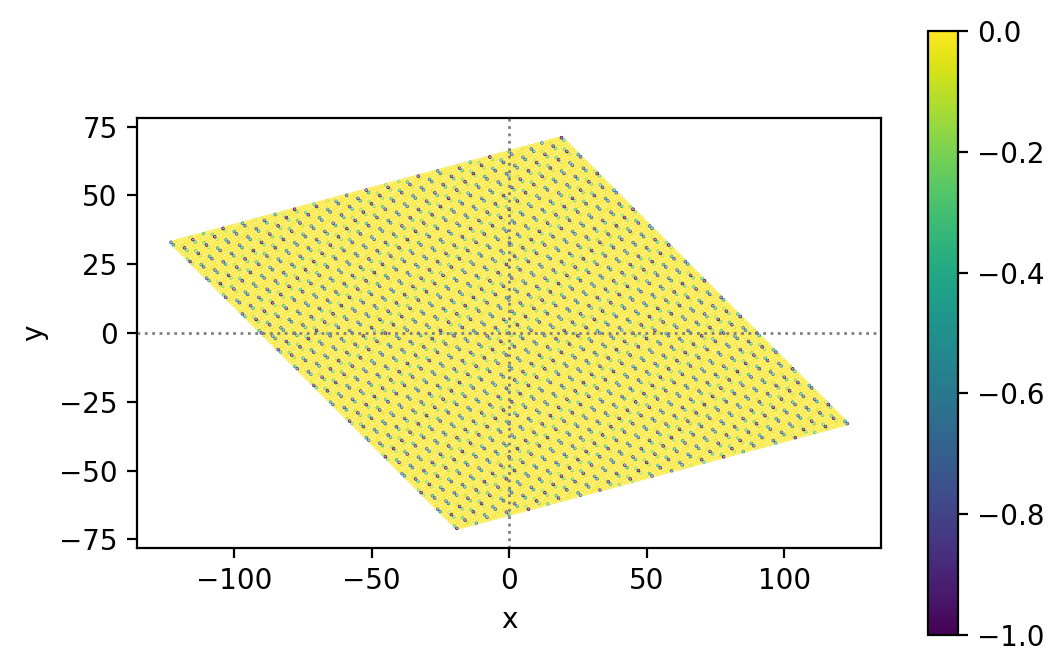

In [36]:
# Create substrate
pen_func, en_func, en_inputs = substrate_from_params(params)

# Create the cluster
pos = cluster_from_params(params)
N = pos.shape[0] # store the number of particles
print("Cluster %s of size N=%i" % (params['cluster_shape'], N))

# It's more convenient to return a cluster in the origin, then shift and rotate outside of the function
pos = rotate(pos, params['theta']) + params['pos_cm']

en, _, _ = pen_func(pos, [0,0], *en_inputs)
# --- Show cluster
pennorm = None #Normalize(-0.05,-0.)
sc = plt.scatter(pos[:,0], pos[:,1], c=en, s=0.1, norm=pennorm)
plt.colorbar(sc)
# plt.quiver(0,0, *params['pos_cm'], angles='xy', scale_units='xy', scale=1)
plt_cosmetic(plt.gca())
plt.gcf().set_dpi(200)
plt.show()

In [32]:
import importlib
import static_trasl_map
importlib.reload(static_trasl_map)
from static_trasl_map import static_traslmap

In [33]:
# You may want to use a coarser grid...
#pp_dens = 100
#pside = 1

t0 = time()
data = static_traslmap(pos, {"da11": -pside, "da12": pside, 
                             "da21": -pside, "da22": pside,
                             "nbin": pp_dens,
                             'S': S, 'en_params': en_inputs}, 
                       en_func, log_propagate=True)
texec = time()-t0
print('Done in %is (%.2fmin)' % (texec, texec/60))
# Separate the output data into components 
pp = data[:,:2]
enmap = data[:,2]
Fxmap = data[:,3]
Fymap = data[:,4]
taumap = data[:,5]

Done in 15s (0.26min)


## Compare 

Norm -0.08975005093652011 -0.03183098861837907 -0.018815015220354905
Use 19 FT components


/Users/andreasilva/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:4192: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


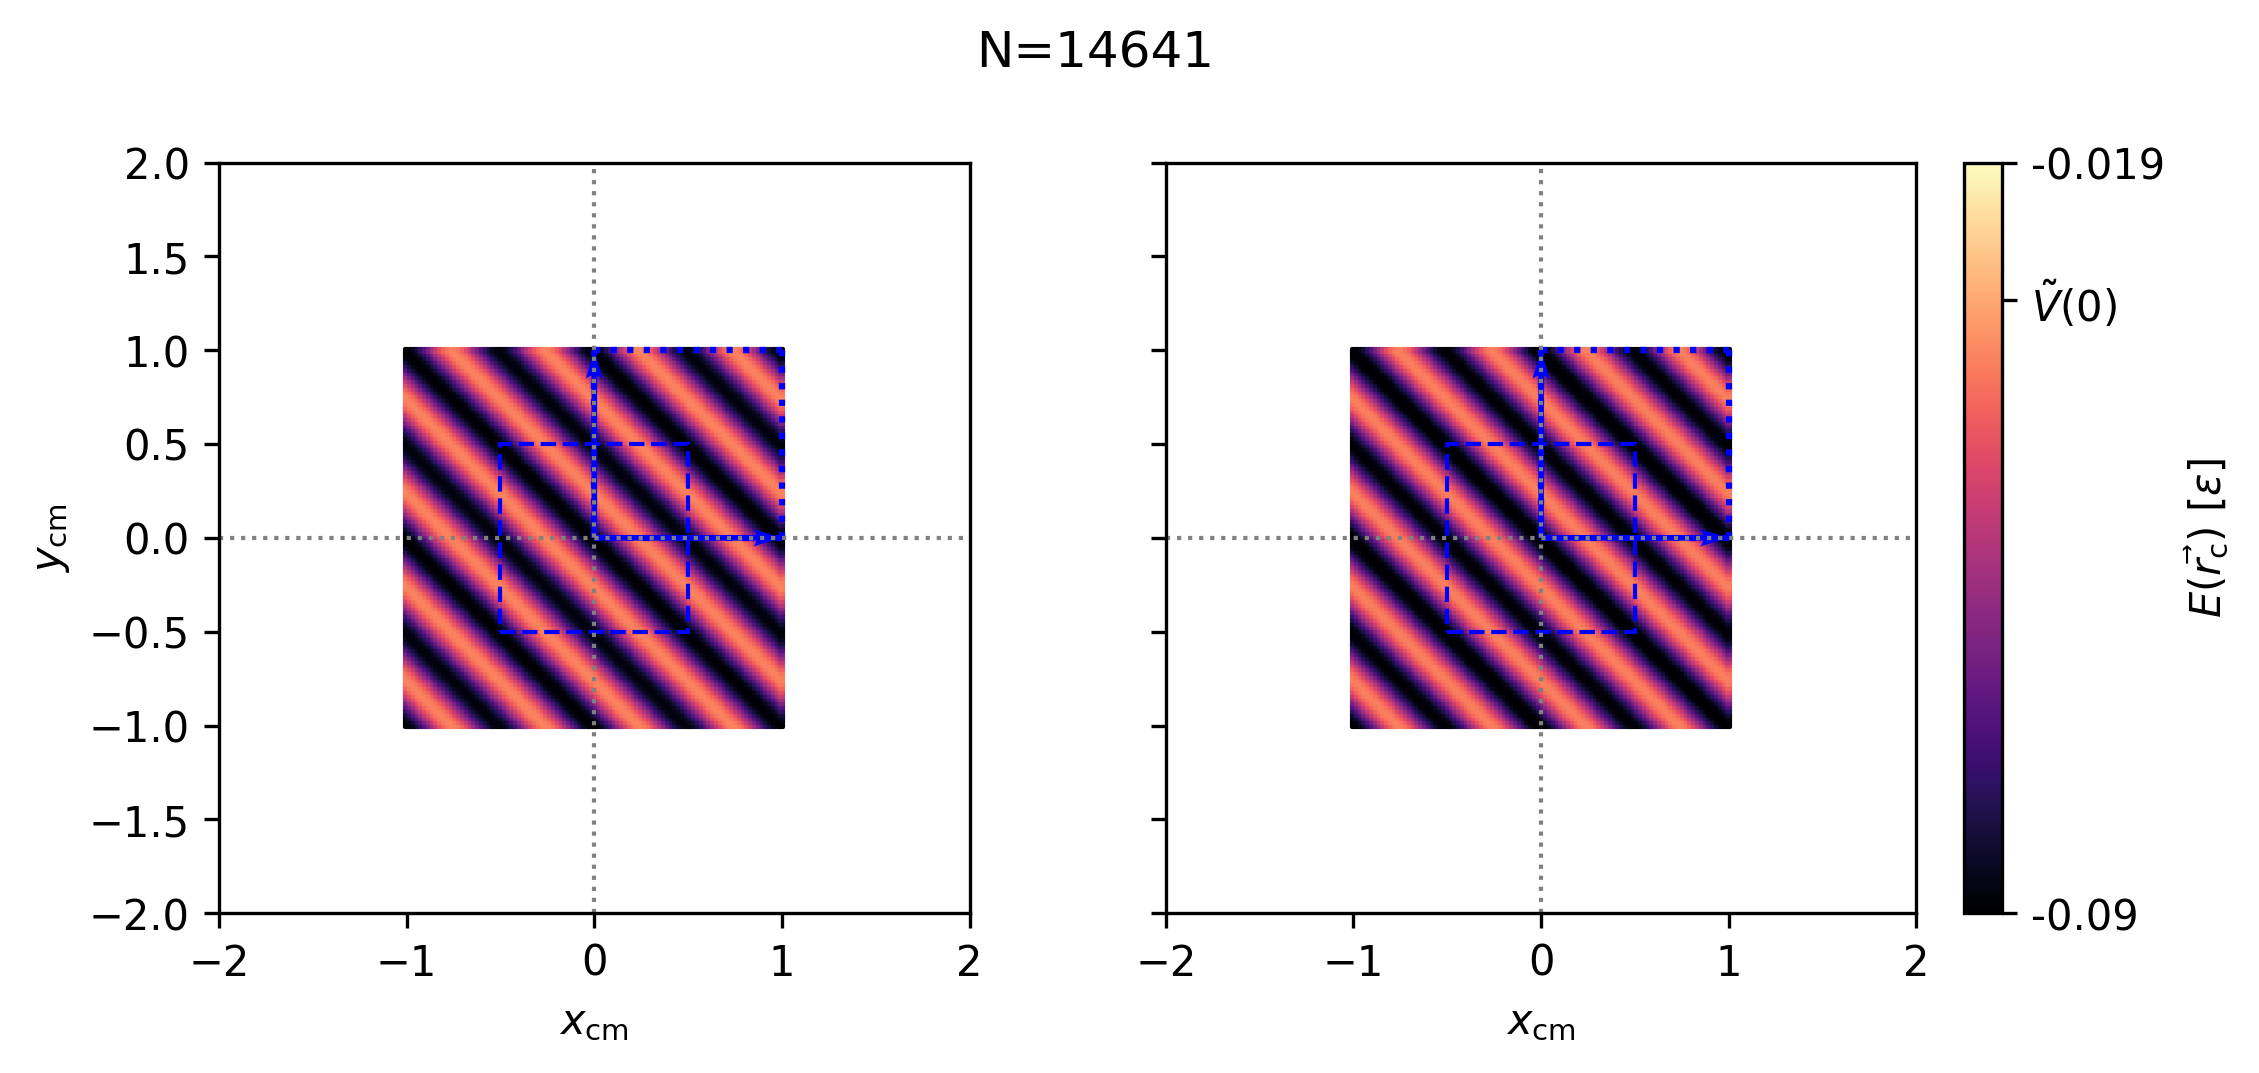

-------------------------------------------------------------------------------- 



In [45]:
# fig, (axE, axEFT) = plt.subplots(2,1, dpi=300, sharex=True, sharey=True, figsize=(4,8))
fig, (axE, axEFT) = plt.subplots(1,2, dpi=300, sharex=True, sharey=True, figsize=(8,3.6))
fig.suptitle('N=%i' % (N))
plt_params = {'ls': '--', 'color': 'tab:gray', 'lw': 1, 'fill': False}
s0 = 0.5 # Size of points
marker = 's'

# --- Plot limits
x0, x1 = -pside, pside
y0, y1 = -pside, pside
x0, x1 = -2.,2.
y0, y1 = -2.,2.


# --- Energy norm
# --- --- Only FT
# ennorm = Normalize(np.min(enFT.real),
#                    np.max(enFT.real))
# --- --- Only test
# ennorm = Normalize(np.min(enmap.flatten()/N),
#                    np.max(enmap.flatten()/N))
# --- --- Both test FT
ennorm = Normalize(np.min(np.concatenate([enmap.flatten()/N, enFT.real])),
                   np.max(np.concatenate([enmap.flatten()/N, enFT.real])))
# --- --- Factor around average (good for superlubric?)
en_eps = VG0*1/50
# ennorm = Normalize(VG0+en_eps, VG0-en_eps)
# --- --- Hybrid
ennorm = Normalize(min([ennorm.vmin, VG0+en_eps]), max([ennorm.vmax, VG0-en_eps]))

print('Norm', ennorm.vmin, VG0, ennorm.vmax)
# --- --- No norm
# ennorm = None

cmap_en = 'magma'
#-------------------------
# --- Discrete 
sc = axE.scatter(pp[:,0], pp[:,1], c=enmap/N, s=s0, marker=marker, norm=ennorm, cmap=cmap_en)
if params['well_shape'] != 'Sin': plot_lat(axE, S, points=False)
axE.set_xlim([x0, x1])
axE.set_ylim([y0, y1])
plt_cosmetic(axE)
axE.set_ylabel(r'$y_\mathrm{cm}$')
axE.set_xlabel(r'$x_\mathrm{cm}$')

#-------------------------
# --- FT
# ppFT = np.dot(np.linalg.inv(B).T, pp0FT.T).T
# ppFT = pp0FT
# !!!!!!!!!!!!!! WHY IS THERE EXCTLY A FACTOR 2 ?!?!?!
#sc = axEFT.scatter(ppFT[:,0], ppFT[:,1], c=enFT, s=s0, marker=marker, norm=ennorm, cmap=cmap_en)
sc = axEFT.scatter(ppFT[:,0], ppFT[:,1], c=2*enFT, s=s0, marker=marker, norm=ennorm, cmap=cmap_en)
cbar = plt.colorbar(sc, label=r'$E_{FT}(x,y)$', ax=axEFT)
cbar.set_label(r'$E(\vec{r_\mathrm{c}})$ [$\epsilon$]')
if ennorm != None:
    cbar.set_ticks([ennorm.vmin, VG0, ennorm.vmax])
    cbar.set_ticklabels([r'%.2g' % (ennorm.vmin), r'$\tilde{V}(0)$', r'%.2g' % (ennorm.vmax)])
if params['well_shape'] != 'Sin':  plot_lat(axEFT, S, points=False)
# --- --- FT components
print('Use %i FT components' % dOmega_s.shape[0])
plt_vecs = False
if plt_vecs:
    for i in range(G_s.shape[0]):
        Gn = np.linalg.norm(G_s[i])
        #Gn = np.linalg.norm(np.dot(B, G0_s[i].T).T)
        realGn = 2*pi*G_s[i]/Gn**2
        #realGn = 2*pi*np.dot(B, G0_s[i].T).T/Gn**2        
        color=Spectral(norm(logweight[i]))
        sc = plt.quiver(0,0, realGn[0], realGn[1],
                        color=color, 
                        angles='xy', scale_units='xy', scale=1)

axEFT.set_xlim([x0, x1])
axEFT.set_ylim([y0, y1])
plt_cosmetic(axEFT)
axEFT.set_xlabel(r'$x_\mathrm{cm}$')
axEFT.set_ylabel('')
#-------------------------

plt.tight_layout()
plt.show()
print('-'*80, '\n')

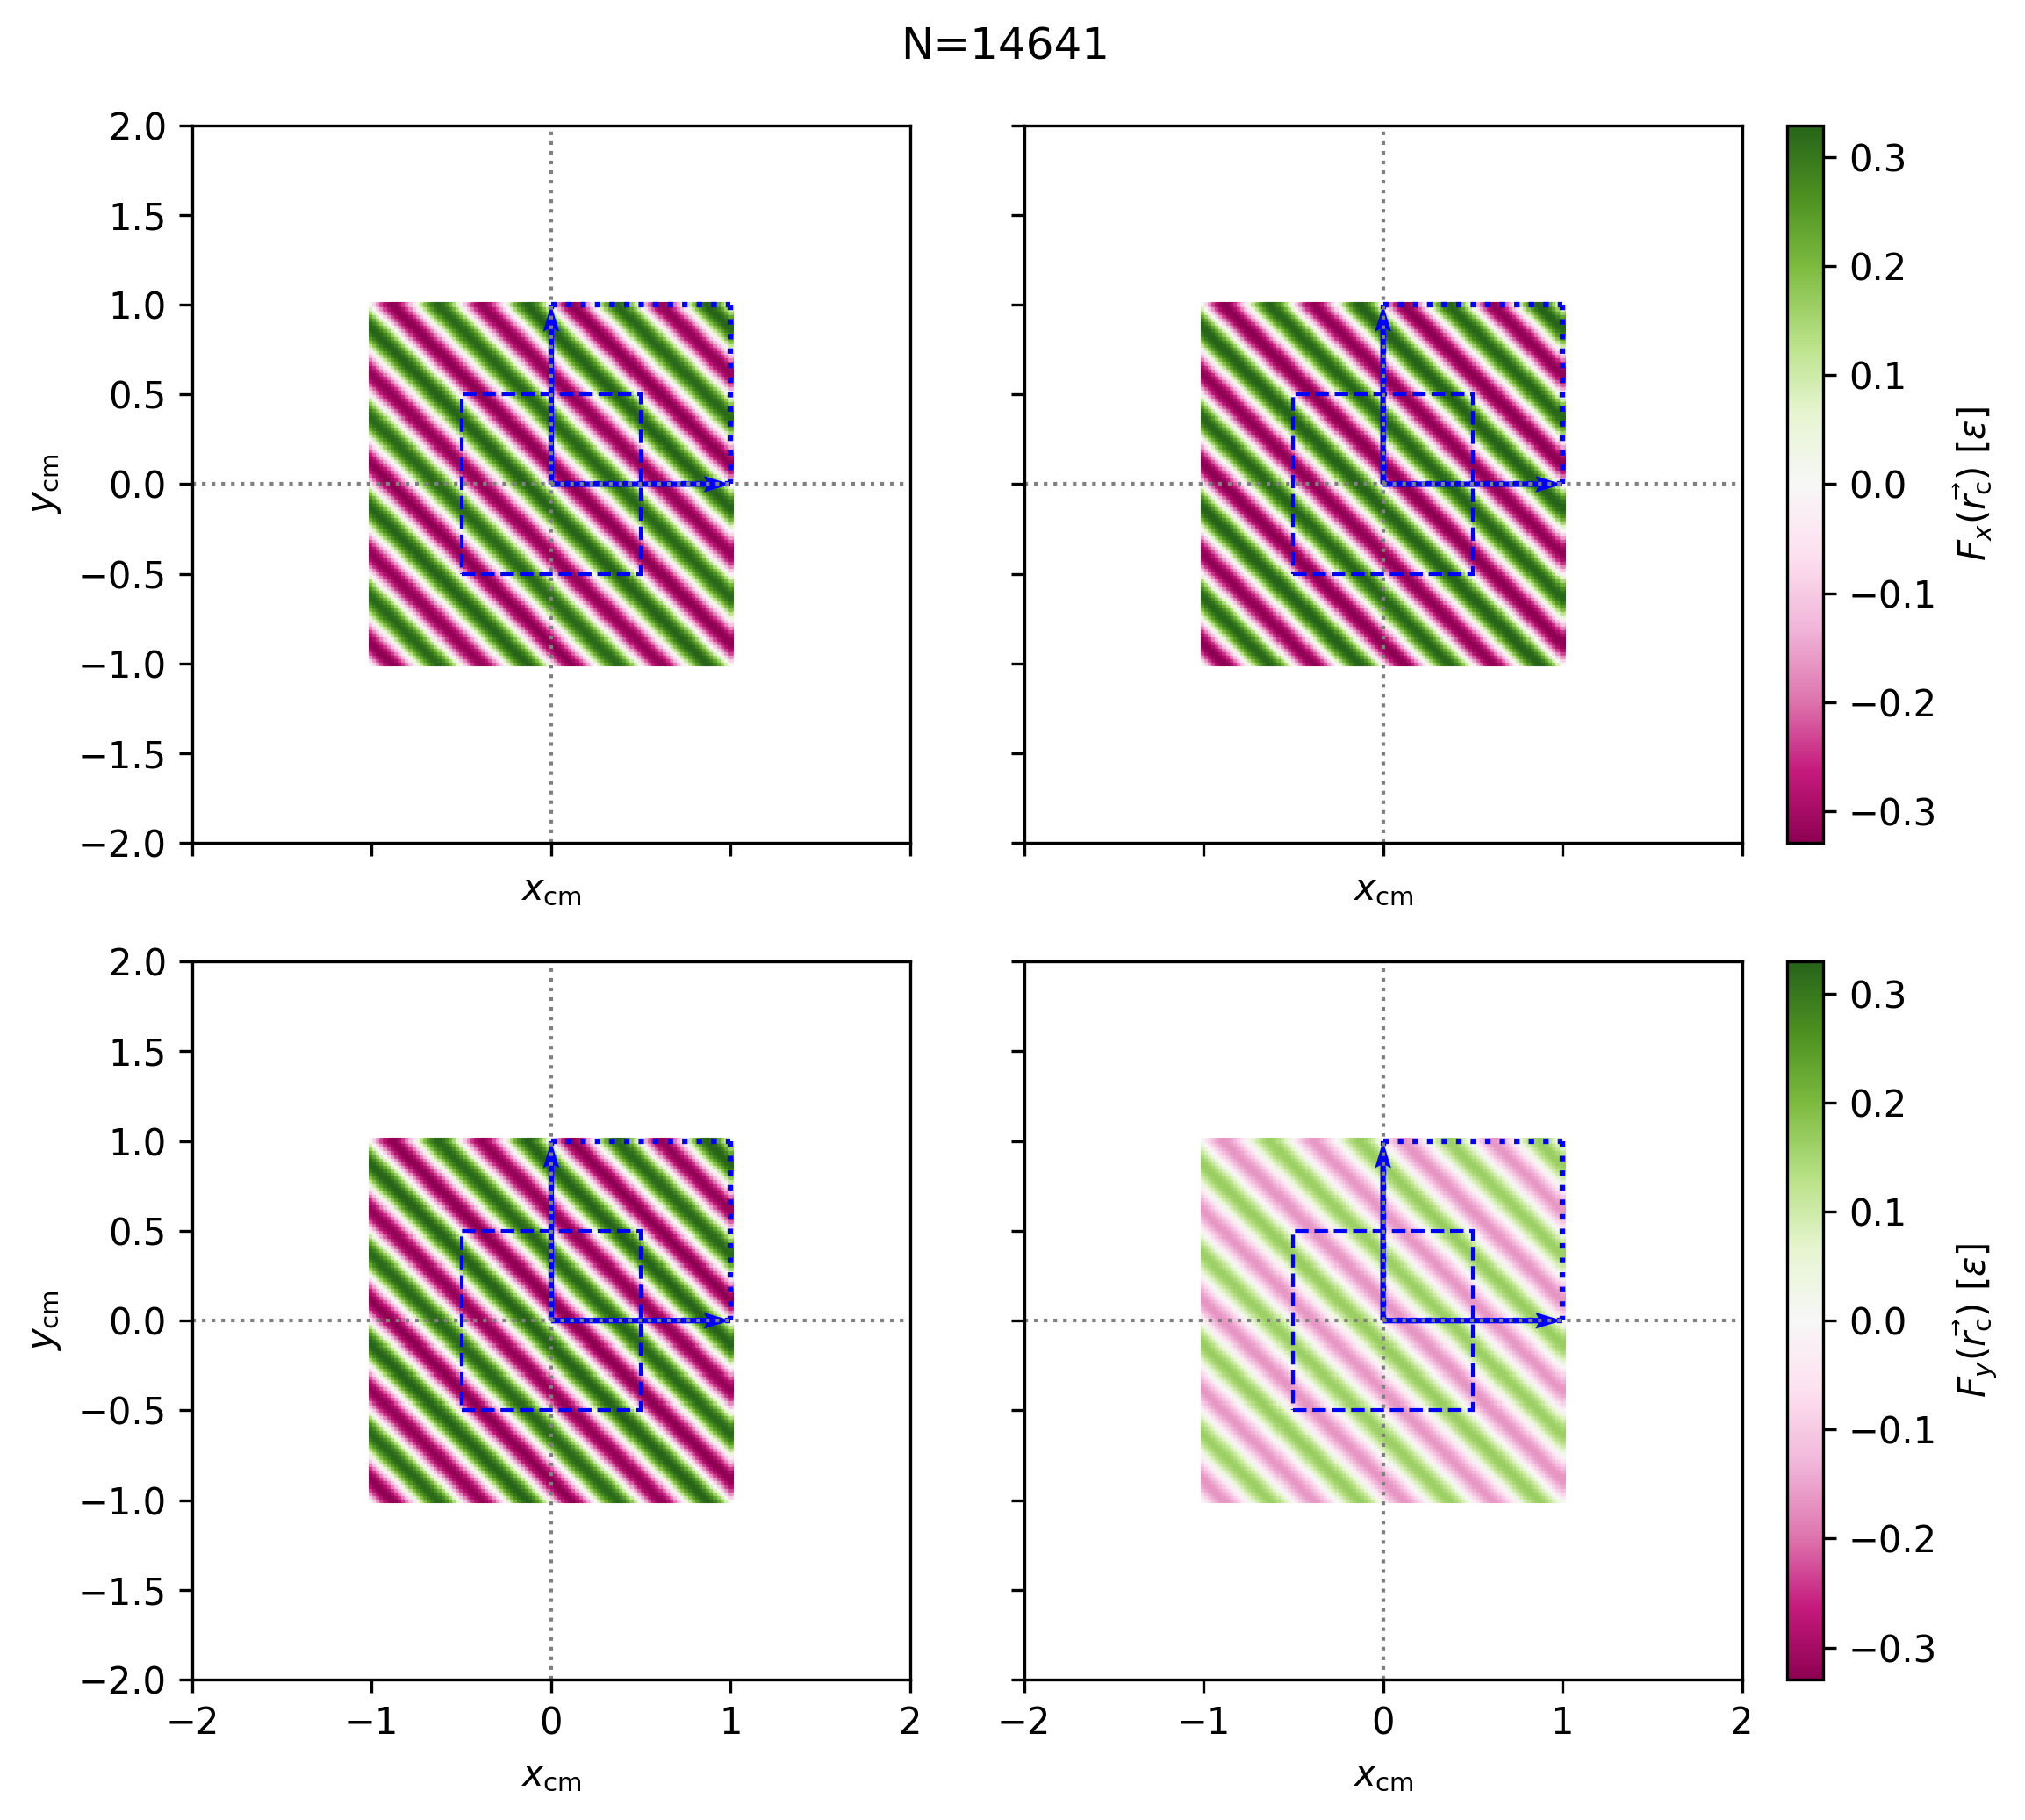

-------------------------------------------------------------------------------- 



In [44]:
# fig, (axFx, axFxFT) = plt.subplots(2,1, dpi=300, sharex=True, sharey=True, figsize=(4,8))
fig, ((axFx, axFxFT), (axFy, axFyFT)) = plt.subplots(2,2, dpi=300, sharex=True, sharey=True, figsize=(8,7))
fig.suptitle('N=%i' % (N))

# --- --- No norm

cmap_en = 'PiYG'
Fxnorm = Normalize(np.min([np.min(Fxmap/N), np.min(FxFT)]), np.max([np.max(Fxmap/N), np.max(FxFT)]))
Fynorm = Normalize(np.min([np.min(Fymap/N), np.min(FyFT)]), np.max([np.max(Fymap/N), np.max(FyFT)]))

Fmin = np.min([np.min(Fxmap/N), np.min(FxFT), np.min(Fymap/N), np.min(FyFT)]) 
Fmax = np.max([np.max(Fxmap/N), np.max(FxFT), np.max(Fymap/N), np.max(FyFT)])
Fxnorm = Normalize(Fmin, Fmax)
Fynorm = Fxnorm

# Fxnorm = Normalize(-0.1,0.1)
# Fynorm = Normalize(-0.1,0.1)

# Fxnorm = Normalize(-0.1,0.1)
# Fynorm = Normalize(-0.1,0.1)
#-------------------------
# --- Discrete 
sc = axFx.scatter(pp[:,0], pp[:,1], c=Fxmap/N, s=s0, marker=marker, norm=Fxnorm, cmap=cmap_en)
if params['well_shape'] != 'Sin': plot_lat(axFx, S, points=False)
axFx.set_xlim([x0, x1])
axFx.set_ylim([y0, y1])
plt_cosmetic(axFx)
axFx.set_ylabel(r'$y_\mathrm{cm}$')
axFx.set_xlabel(r'$x_\mathrm{cm}$')

sc = axFy.scatter(pp[:,0], pp[:,1], c=Fymap/N, s=s0, marker=marker, norm=Fynorm, cmap=cmap_en)
if params['well_shape'] != 'Sin': plot_lat(axFy, S, points=False)
axFy.set_xlim([x0, x1])
axFy.set_ylim([y0, y1])
plt_cosmetic(axFy)
axFy.set_ylabel(r'$y_\mathrm{cm}$')
axFy.set_xlabel(r'$x_\mathrm{cm}$')
#-------------------------
# --- FT
# ppFT = np.dot(np.linalg.inv(B).T, pp0FT.T).T
# ppFT = pp0FT
sc = axFxFT.scatter(ppFT[:,0], ppFT[:,1], c=FxFT, s=s0, marker=marker, norm=Fxnorm, cmap=cmap_en)
cbar = plt.colorbar(sc, label=r'$E_{FT}(x,y)$', ax=axFxFT)
cbar.set_label(r'$F_x(\vec{r_\mathrm{c}})$ [$\epsilon$]')
if params['well_shape'] != 'Sin': plot_lat(axFxFT, S, points=False)
axFxFT.set_xlim([x0, x1])
axFxFT.set_ylim([y0, y1])
plt_cosmetic(axFxFT)
axFxFT.set_xlabel(r'$x_\mathrm{cm}$')
axFxFT.set_ylabel('')

sc = axFyFT.scatter(ppFT[:,0], ppFT[:,1], c=FyFT, s=s0, marker=marker, norm=Fynorm, cmap=cmap_en)
cbar = plt.colorbar(sc, label=r'$E_{FT}(x,y)$', ax=axFyFT)
cbar.set_label(r'$F_y(\vec{r_\mathrm{c}})$ [$\epsilon$]')
if params['well_shape'] != 'Sin': plot_lat(axFyFT, S, points=False)
axFyFT.set_xlim([x0, x1])
axFyFT.set_ylim([y0, y1])
plt_cosmetic(axFyFT)
axFyFT.set_xlabel(r'$x_\mathrm{cm}$')
axFyFT.set_ylabel('')



#-------------------------

plt.tight_layout()
plt.show()
print('-'*80, '\n')